# **1. MOUNT GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. INSTALL ULTRALYTICS**

In [2]:
import subprocess
import sys

In [3]:
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--upgrade"])

install_package("ultralytics")

# **3. UNZIP DATASET**

In [4]:
import zipfile
import os

In [5]:
dataset_zip_path = "/content/drive/MyDrive/Model_Training/License_Plate_Recognition/Number Plate Detection Sri Lanka.yolov11.zip"
dataset_extract_path = "/content/dataset"

try:
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_extract_path)
    print("✅ Dataset extracted successfully!")
except FileNotFoundError:
    print("❌ Dataset zip file not found! Please check the path:")
    print(f"Looking for: {dataset_zip_path}")
    print("Make sure your zip file is in the correct location.")

✅ Dataset extracted successfully!


# **4. CHECK DATASET STRUCTURE**

In [6]:
import yaml

In [7]:
print("\n🔍 Checking dataset structure...")
import yaml

def check_dataset_structure():
    print("Dataset structure:")
    for root, dirs, files in os.walk("/content/dataset"):
        level = root.replace("/content/dataset", "").count(os.sep)
        indent = " " * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

    print("\n" + "="*50)
    print("data.yaml content:")
    try:
        with open("/content/dataset/data.yaml", "r") as f:
            data_config = yaml.safe_load(f)
            print(data_config)
    except FileNotFoundError:
        print("❌ data.yaml not found!")
        return False

    train_images = 0
    val_images = 0
    test_images = 0

    try:
        train_images = len([f for f in os.listdir("/content/dataset/train/images")
                          if f.endswith(('.jpg', '.jpeg', '.png'))])
        val_images = len([f for f in os.listdir("/content/dataset/valid/images")
                         if f.endswith(('.jpg', '.jpeg', '.png'))])

        if os.path.exists("/content/dataset/test/images"):
            test_images = len([f for f in os.listdir("/content/dataset/test/images")
                              if f.endswith(('.jpg', '.jpeg', '.png'))])
    except FileNotFoundError as e:
        print(f"❌ Error counting images: {e}")
        return False

    print(f"\nImage counts:")
    print(f"Train: {train_images} images")
    print(f"Validation: {val_images} images")
    if test_images > 0:
        print(f"Test: {test_images} images")
    else:
        print("Test: No test folder (this is fine - validation will be used for testing)")
    print(f"Total: {train_images + val_images + test_images} images")

    if train_images > 0 and val_images > 0:
        train_ratio = train_images / (train_images + val_images)
        val_ratio = val_images / (train_images + val_images)
        print(f"\nDataset split ratio:")
        print(f"Train: {train_ratio:.1%} ({train_images} images)")
        print(f"Validation: {val_ratio:.1%} ({val_images} images)")

        if val_ratio < 0.15:
            print("⚠️  Warning: Validation set is quite small (<15%). Consider having at least 15-20% for validation.")
        elif val_ratio > 0.3:
            print("⚠️  Note: Large validation set (>30%). You could move some images to training for better learning.")
        else:
            print("✅ Good train/validation split ratio!")

        if train_images == 921 and val_images == 77:
            print("🇱🇰 Sri Lankan License Plate Dataset detected!")
            print(f"Split ratio: {train_ratio:.1%} train / {val_ratio:.1%} validation")
            print("✅ This is a good split for your dataset size!")

    return True

dataset_ok = check_dataset_structure()

if not dataset_ok:
    print("❌ Dataset check failed. Please fix the issues before proceeding.")
    exit()


🔍 Checking dataset structure...
Dataset structure:
dataset/
  data.yaml
  README.dataset.txt
  README.roboflow.txt
  valid/
    images/
      36_plate_1_png.rf.246c327354689dc64051399689383893.jpg
      176_plate_1_png.rf.8c5615979ab999645c64f2a2447ea0d3.jpg
      70_plate_1_png.rf.26e498c51302c99ffa07f123e8964928.jpg
      79_plate_1_png.rf.36b07c79b11cf2a6f28d69e8f19bf158.jpg
      180_plate_1_png.rf.cd863d5c262c363cf3b7cb7135d825f3.jpg
      ... and 72 more files
    labels/
      28_plate_1_png.rf.8e94030e0461c7f2b66811ff5e9f8ff7.txt
      151_plate_1_png.rf.b867d0f2fd3da1f2d8ab8e522b0b4186.txt
      186_plate_1_png.rf.81dbc42ed400e0e56b30f928e7e0275d.txt
      192_plate_1_png.rf.26434f385c3aac24bbe702ebc0163957.txt
      38_plate_1_png.rf.77aa153840325d5e2db6c0ba9004c886.txt
      ... and 72 more files
  train/
    images/
      336_png.rf.d049c7010d788d6359068056eff6b472.jpg
      453_png.rf.f2f1c9bd50c375067eeae61e92585adf.jpg
      473_png.rf.6c2adba295778c130650eef4a65c3e35.j

# **5. TRAIN YOLOv11s MODEL**

In [8]:
from ultralytics import YOLO
import urllib.request
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
model_path = "yolo11s.pt"
drive_model_path = "/content/drive/MyDrive/Model_Training/License_Plate_Recognition/yolo11s.pt"

print("🔍 Checking for YOLOv11s model...")

if os.path.exists(drive_model_path):
    print("✅ Found yolov11s.pt in Google Drive, copying to workspace...")
    shutil.copy2(drive_model_path, model_path)
    print("✅ Model copied successfully!")
elif os.path.exists(model_path):
    print("✅ Found yolov11s.pt in workspace")
else:
    print("📥 YOLOv11s model not found, downloading automatically...")
    try:
        os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)

        print("⏳ Downloading YOLOv11s model (this may take a few minutes)...")

        from ultralytics.utils.downloads import download
        model_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov11s.pt"

        temp_model = YOLO("yolo11s.pt")
        model_path = "yolo11s.pt"

        print("✅ YOLOv11s model downloaded successfully!")

        print("💾 Saving model to Google Drive for future use...")
        shutil.copy2(model_path, drive_model_path)
        print("✅ Model saved to Google Drive!")

    except Exception as e:
        print(f"❌ Error with automatic download: {e}")
        print("🔄 Trying manual download method...")
        try:
            model_urls = [
                "https://github.com/ultralytics/assets/releases/download/v0.0.0/yolo11s.pt",
                "https://github.com/ultralytics/assets/releases/download/v8.2.0/yolo11s.pt",
                "https://github.com/ultralytics/ultralytics/releases/download/v8.0.0/yolo11s.pt"
            ]

            downloaded = False
            for url in model_urls:
                try:
                    print(f"⏳ Trying: {url}")
                    urllib.request.urlretrieve(url, model_path)
                    print("✅ Model downloaded successfully!")
                    downloaded = True
                    break
                except Exception as url_error:
                    print(f"❌ Failed: {url_error}")
                    continue

            if downloaded:
                shutil.copy2(model_path, drive_model_path)
                print("✅ Model saved to Google Drive!")
            else:
                raise Exception("All download URLs failed")

        except Exception as e2:
            print(f"❌ All download methods failed: {e2}")
            print("🔧 Using alternative approach...")

            subprocess.run([sys.executable, "-m", "pip", "install", "ultralytics", "--upgrade"],
                          capture_output=True)

            try:
                temp_model = YOLO()
                model = YOLO("yolo11s.pt")
                model_path = "yolo11s.pt"
                print("✅ Model initialized successfully!")

                if os.path.exists(model_path):
                    shutil.copy2(model_path, drive_model_path)
                    print("✅ Model saved to Google Drive!")
            except Exception as e3:
                print(f"❌ Final attempt failed: {e3}")
                print("🚨 Please manually download yolo11s.pt and upload to Google Drive")
                print("Download from: https://github.com/ultralytics/assets/releases/")
                exit()

print("🤖 Loading YOLOv11s model...")
model = YOLO(model_path)

training_params = {
    "data": "/content/dataset/data.yaml",
    "epochs": 120,
    "imgsz": 640,
    "batch": 16,
    "device": 0,
    "patience": 25,
    "name": "sri_lanka_license_plate_detection"
}

print("Training parameters:")
for key, value in training_params.items():
    print(f"  {key}: {value}")

print("\n🏋️ Training started... This may take a while!")
print("You can monitor progress in the output below.")

results = model.train(**training_params)

print("✅ Training completed!")

🔍 Checking for YOLOv11s model...
📥 YOLOv11s model not found, downloading automatically...
⏳ Downloading YOLOv11s model (this may take a few minutes)...


100%|██████████| 18.4M/18.4M [00:00<00:00, 95.5MB/s]


✅ YOLOv11s model downloaded successfully!
💾 Saving model to Google Drive for future use...
✅ Model saved to Google Drive!
🤖 Loading YOLOv11s model...
Training parameters:
  data: /content/dataset/data.yaml
  epochs: 120
  imgsz: 640
  batch: 16
  device: 0
  patience: 25
  name: sri_lanka_license_plate_detection

🏋️ Training started... This may take a while!
You can monitor progress in the output below.
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fals

100%|██████████| 755k/755k [00:00<00:00, 17.2MB/s]

Overriding model.yaml nc=80 with nc=37

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512,

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 342.9±315.1 MB/s, size: 12.3 KB)


train: Scanning /content/dataset/train/labels... 921 images, 0 backgrounds, 0 corrupt: 100%|██████████| 921/921 [00:00<00:00, 2168.64it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 107.4±28.5 MB/s, size: 3.4 KB)


val: Scanning /content/dataset/valid/labels... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<00:00, 1677.94it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/detect/sri_lanka_license_plate_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000244, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/sri_lanka_license_plate_detection
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      4.08G      1.371      3.497      1.308        127        640: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         77        534      0.729      0.252      0.281      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      4.43G      1.069      1.395      1.103        137        640: 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         77        534      0.794       0.56      0.639      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      4.47G     0.9852     0.9764      1.072        133        640: 100%|██████████| 58/58 [00:19<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         77        534      0.827      0.843      0.906      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      4.51G     0.9496     0.8052      1.061        151        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


                   all         77        534      0.896      0.856      0.928      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      4.55G      0.906      0.718      1.043        118        640: 100%|██████████| 58/58 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         77        534      0.913      0.892      0.945      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      4.59G     0.8765     0.6692      1.032        162        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         77        534      0.878      0.913      0.951      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      4.63G     0.8755     0.6351      1.031        117        640: 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


                   all         77        534      0.867      0.928      0.966      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      4.67G     0.8568     0.5893      1.021        145        640: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         77        534      0.927      0.918      0.964      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      4.71G     0.8352     0.5806       1.02        140        640: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         77        534      0.939      0.924      0.958      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      4.75G     0.8145     0.5535      1.006        176        640: 100%|██████████| 58/58 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         77        534       0.92      0.925      0.951      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      4.79G     0.8154     0.5414      1.005        153        640: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         77        534      0.884      0.977      0.976      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      4.83G     0.8096      0.526     0.9993        125        640: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         77        534      0.893      0.964      0.972      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      4.87G     0.7891     0.5126     0.9957        113        640: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         77        534      0.936      0.939      0.964      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      4.91G     0.7936     0.5053     0.9985        163        640: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         77        534      0.946      0.915      0.963        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      4.95G     0.7872      0.503     0.9941        108        640: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.963      0.902      0.963      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      4.99G     0.7705     0.4824     0.9846        121        640: 100%|██████████| 58/58 [00:18<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         77        534       0.88      0.932      0.952      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      5.03G     0.7581     0.4704     0.9838        108        640: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


                   all         77        534      0.962      0.862      0.946      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      5.06G     0.7523     0.4661      0.976        111        640: 100%|██████████| 58/58 [00:19<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         77        534      0.946      0.922      0.973      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      5.11G     0.7471     0.4503     0.9806        134        640: 100%|██████████| 58/58 [00:18<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.951      0.906      0.949      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      5.14G     0.7425     0.4548     0.9709        127        640: 100%|██████████| 58/58 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         77        534      0.853      0.945       0.96      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      5.19G     0.7295     0.4483     0.9679        134        640: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         77        534      0.922      0.902      0.951       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      5.22G      0.729     0.4485     0.9658        135        640: 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         77        534       0.93      0.931      0.967      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      5.26G     0.7223     0.4381      0.964        134        640: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         77        534      0.934      0.898      0.954      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120       5.6G     0.7013     0.4223     0.9593        105        640: 100%|██████████| 58/58 [00:18<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         77        534      0.952      0.891      0.962      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      5.64G      0.709     0.4258       0.96        119        640: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         77        534      0.931      0.892      0.951      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      5.68G      0.701     0.4187     0.9543        140        640: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         77        534      0.883      0.938      0.962      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      5.72G     0.6844      0.412     0.9511        162        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


                   all         77        534      0.905      0.952      0.966      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      5.76G     0.6791     0.4141      0.948        117        640: 100%|██████████| 58/58 [00:19<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         77        534      0.922      0.912      0.956      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120       5.8G     0.6788     0.4105     0.9509        137        640: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.908      0.919      0.966      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      5.84G     0.6705     0.4024     0.9478        147        640: 100%|██████████| 58/58 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         77        534      0.895      0.941      0.961      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      5.88G     0.6749     0.3982     0.9431        128        640: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         77        534      0.953      0.915      0.964      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      5.92G     0.6623     0.3993     0.9393        132        640: 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


                   all         77        534      0.926       0.91      0.963      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      5.96G     0.6578     0.3992     0.9465        118        640: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         77        534      0.902      0.945      0.964      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120         6G     0.6502     0.3928     0.9327        144        640: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         77        534      0.911      0.908      0.953      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      6.04G     0.6478     0.3919     0.9389        148        640: 100%|██████████| 58/58 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         77        534      0.916      0.925      0.962      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      6.08G     0.6384     0.3727     0.9284        154        640: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all         77        534       0.89      0.935      0.968      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      6.12G     0.6392     0.3795     0.9349        105        640: 100%|██████████| 58/58 [00:18<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         77        534      0.961      0.933      0.972      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      6.16G     0.6295     0.3743     0.9281        117        640: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         77        534       0.97      0.902      0.973      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120       6.2G     0.6276      0.376     0.9263        114        640: 100%|██████████| 58/58 [00:18<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         77        534      0.911      0.941      0.966      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      6.23G     0.6173     0.3717     0.9253        135        640: 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         77        534      0.947      0.924      0.969      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      6.28G     0.6237     0.3762     0.9273         86        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         77        534      0.903      0.927      0.964      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      6.31G     0.6084     0.3652     0.9203        133        640: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


                   all         77        534      0.944      0.931      0.965        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      6.36G     0.5957     0.3591      0.914        123        640: 100%|██████████| 58/58 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.897      0.954      0.964      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      6.39G     0.6081     0.3563     0.9196        143        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all         77        534      0.919       0.94      0.967      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      6.43G     0.6006     0.3626      0.917        131        640: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         77        534      0.943      0.929      0.966       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      6.47G     0.6002     0.3596     0.9225         99        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         77        534      0.935       0.91      0.964      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      6.51G     0.5953     0.3556      0.914        112        640: 100%|██████████| 58/58 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


                   all         77        534      0.903      0.937      0.966      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      6.55G     0.5795     0.3437      0.909        126        640: 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         77        534      0.931      0.909      0.965      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      6.59G     0.5758     0.3452      0.914        123        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         77        534      0.905      0.949      0.965      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      6.63G     0.5766     0.3435     0.9054        112        640: 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         77        534      0.893       0.94      0.957      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      6.71G     0.5673     0.3404      0.903        138        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         77        534      0.876      0.952       0.96        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      6.75G     0.5611     0.3359     0.9016        152        640: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


                   all         77        534      0.908      0.931      0.976      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      6.79G     0.5644     0.3391     0.9029        107        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         77        534      0.861      0.934      0.959      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      6.87G     0.5549     0.3308     0.8991         79        640: 100%|██████████| 58/58 [00:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         77        534      0.958      0.894      0.966      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      6.91G     0.5558     0.3284     0.8927        136        640: 100%|██████████| 58/58 [00:19<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.952      0.925      0.974      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      6.98G     0.5492     0.3271     0.8932        164        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         77        534      0.964      0.887      0.973      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      7.02G     0.5464      0.325     0.8973        104        640: 100%|██████████| 58/58 [00:21<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         77        534      0.882      0.918      0.959        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      7.06G      0.537      0.328     0.8961        158        640: 100%|██████████| 58/58 [00:18<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         77        534      0.844      0.949      0.963      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      7.14G     0.5457     0.3283     0.8991        136        640: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


                   all         77        534      0.865      0.949      0.962      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      7.18G     0.5346      0.319     0.8881        137        640: 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         77        534      0.951      0.893      0.975      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      7.22G     0.5175     0.3167     0.8836        104        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         77        534      0.871      0.957      0.978      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120       7.3G     0.5187     0.3181     0.8888        133        640: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         77        534      0.946      0.908      0.975      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      7.34G     0.5207     0.3167     0.8883        146        640: 100%|██████████| 58/58 [00:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         77        534      0.915      0.931      0.965      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      7.41G     0.5318     0.3179     0.8918        155        640: 100%|██████████| 58/58 [00:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         77        534      0.862      0.947       0.97      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      4.39G     0.5204     0.3183     0.8847        101        640: 100%|██████████| 58/58 [00:18<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         77        534      0.875      0.895      0.946       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.39G     0.5182     0.3144     0.8877        130        640: 100%|██████████| 58/58 [00:19<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


                   all         77        534      0.954      0.882      0.959      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      4.39G      0.522     0.3105     0.8876        146        640: 100%|██████████| 58/58 [00:19<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         77        534      0.929      0.881      0.957      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.39G     0.5148     0.3069     0.8865        136        640: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


                   all         77        534      0.881      0.939      0.961      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      4.39G      0.498     0.3051     0.8838        136        640: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         77        534       0.89       0.96       0.96      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      4.39G     0.4995     0.3024     0.8807        152        640: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         77        534      0.899      0.932      0.959      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      4.41G     0.4973     0.3063     0.8809         99        640: 100%|██████████| 58/58 [00:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         77        534      0.904      0.936      0.957      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.45G     0.4991     0.3053     0.8793        139        640: 100%|██████████| 58/58 [00:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         77        534      0.892      0.938      0.961      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      4.49G     0.4877     0.3005     0.8784        126        640: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


                   all         77        534      0.886      0.938      0.963      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.53G      0.484     0.2981     0.8738        145        640: 100%|██████████| 58/58 [00:18<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         77        534      0.969      0.878       0.96      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      4.56G     0.4795     0.2944     0.8715        115        640: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


                   all         77        534      0.895       0.94       0.96      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.64G     0.4782     0.2915     0.8776        149        640: 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         77        534      0.892      0.937      0.968      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      4.68G     0.4743     0.2883     0.8699        114        640: 100%|██████████| 58/58 [00:19<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         77        534      0.901      0.928      0.966      0.807
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



77 epochs completed in 0.433 hours.
Optimizer stripped from runs/detect/sri_lanka_license_plate_detection/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/sri_lanka_license_plate_detection/weights/best.pt, 19.2MB

Validating runs/detect/sri_lanka_license_plate_detection/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,427,119 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


                   all         77        534      0.908      0.931      0.976      0.814
                     -         19         19      0.952          1      0.995      0.667
                     0         28         32      0.982      0.969      0.977      0.814
                     1         22         26          1      0.957      0.994      0.847
                     2         38         40      0.963          1      0.995      0.847
                     3         27         29      0.972          1      0.995      0.803
                     4         20         27      0.976          1      0.995      0.762
                     5         26         31      0.975          1      0.995       0.86
                     6         27         33      0.955       0.97      0.966      0.789
                     7         27         29       0.97          1      0.995       0.82
                     8         21         25      0.972          1      0.995       0.83
                     

# **6. DISPLAY TRAINING RESULTS**

In [10]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import glob

Training curves:


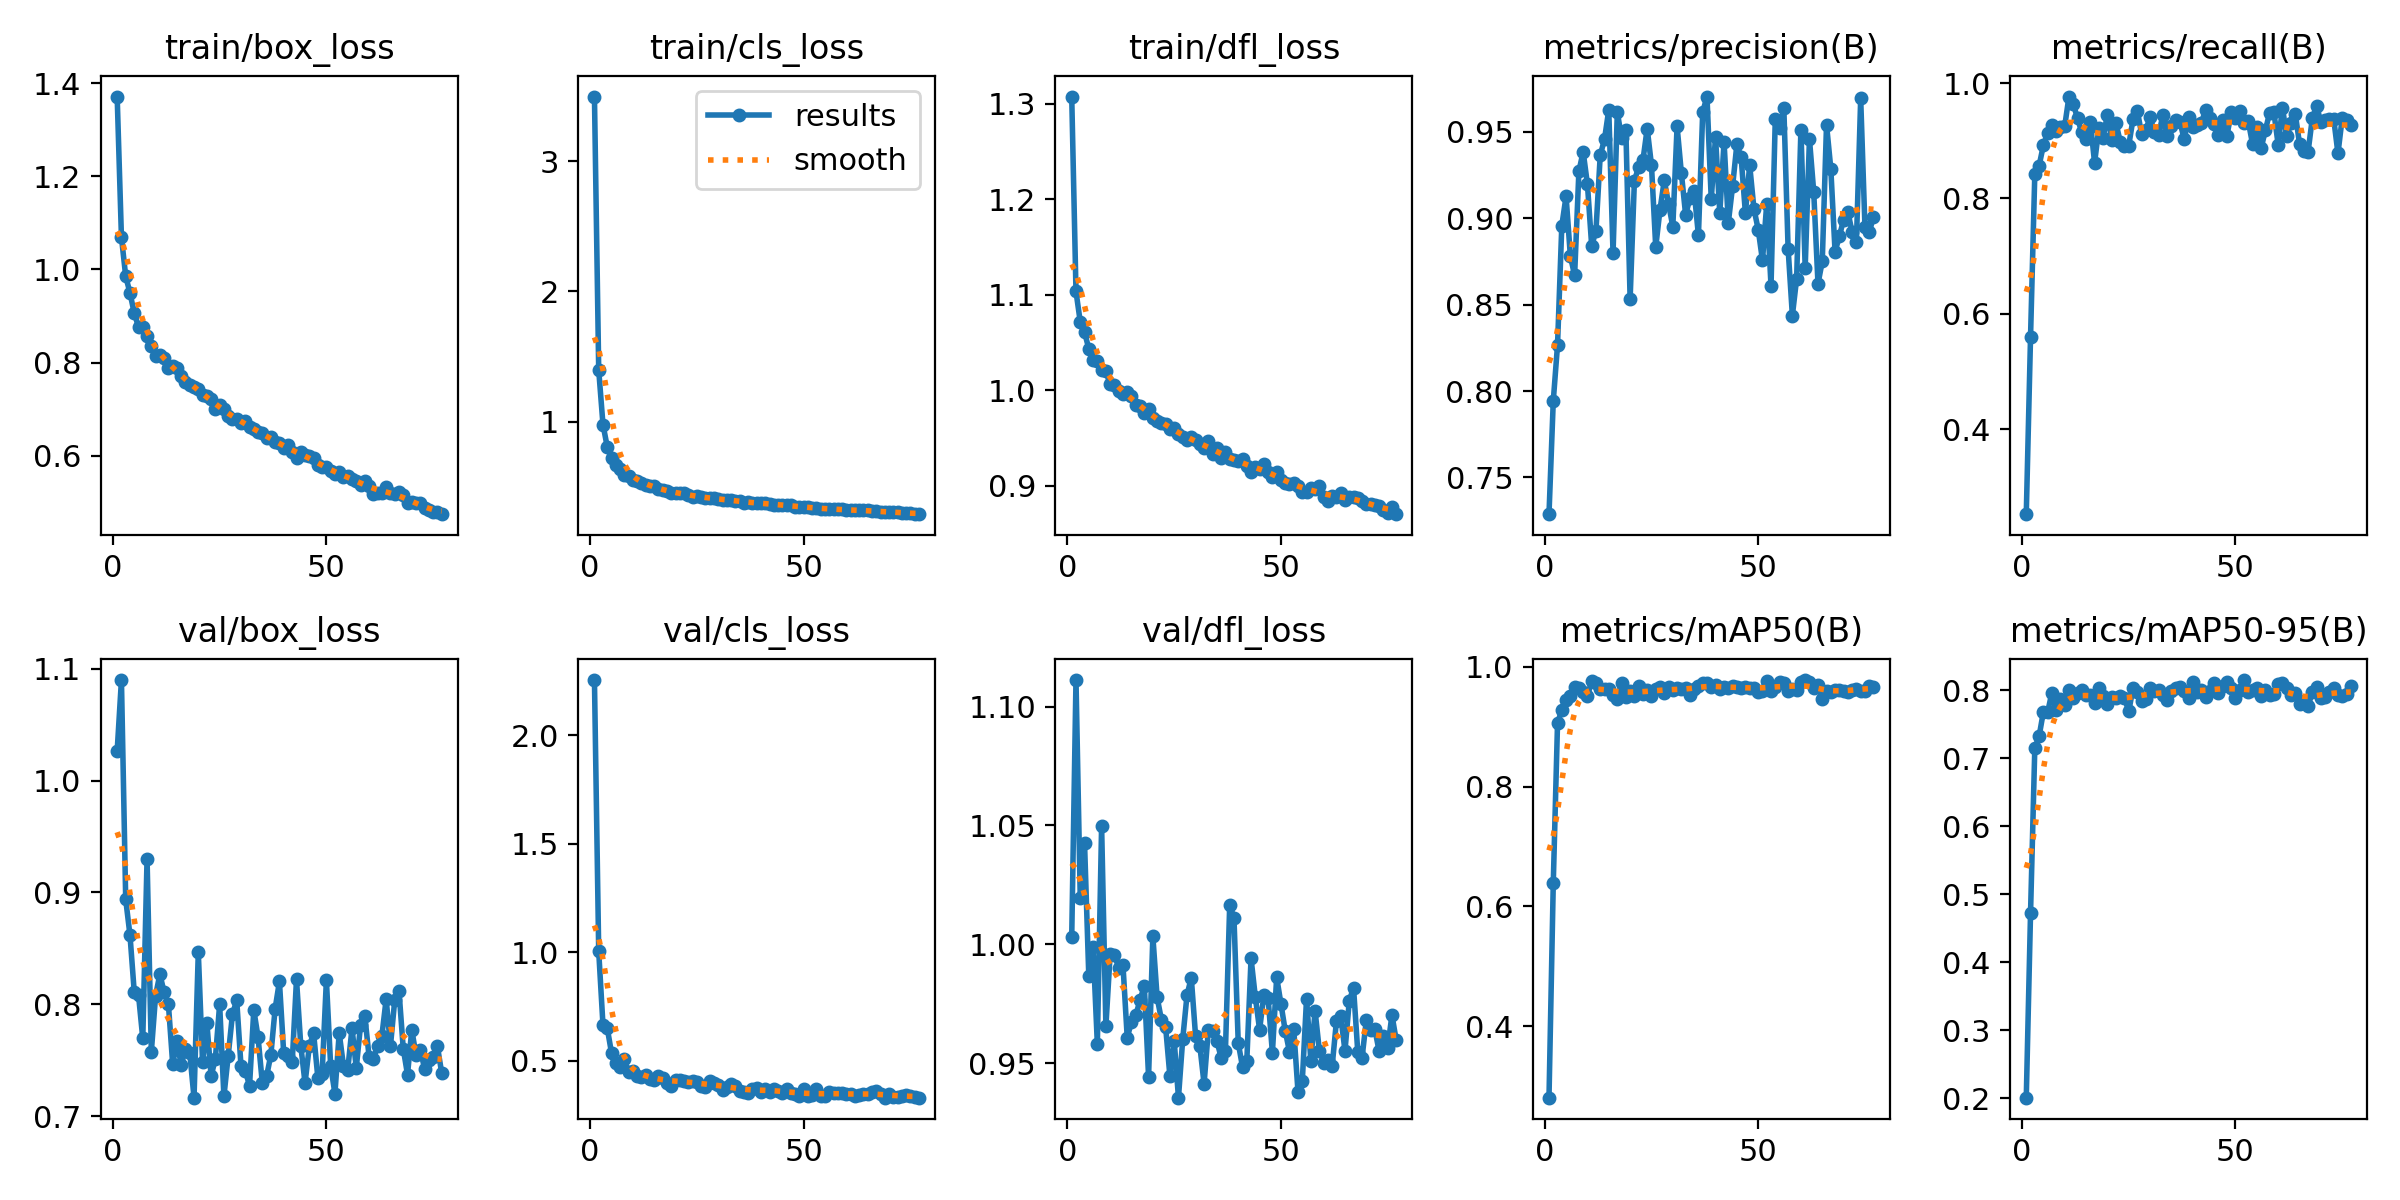


📊 Training and Validation Batch Images:
Training Batch Sample:


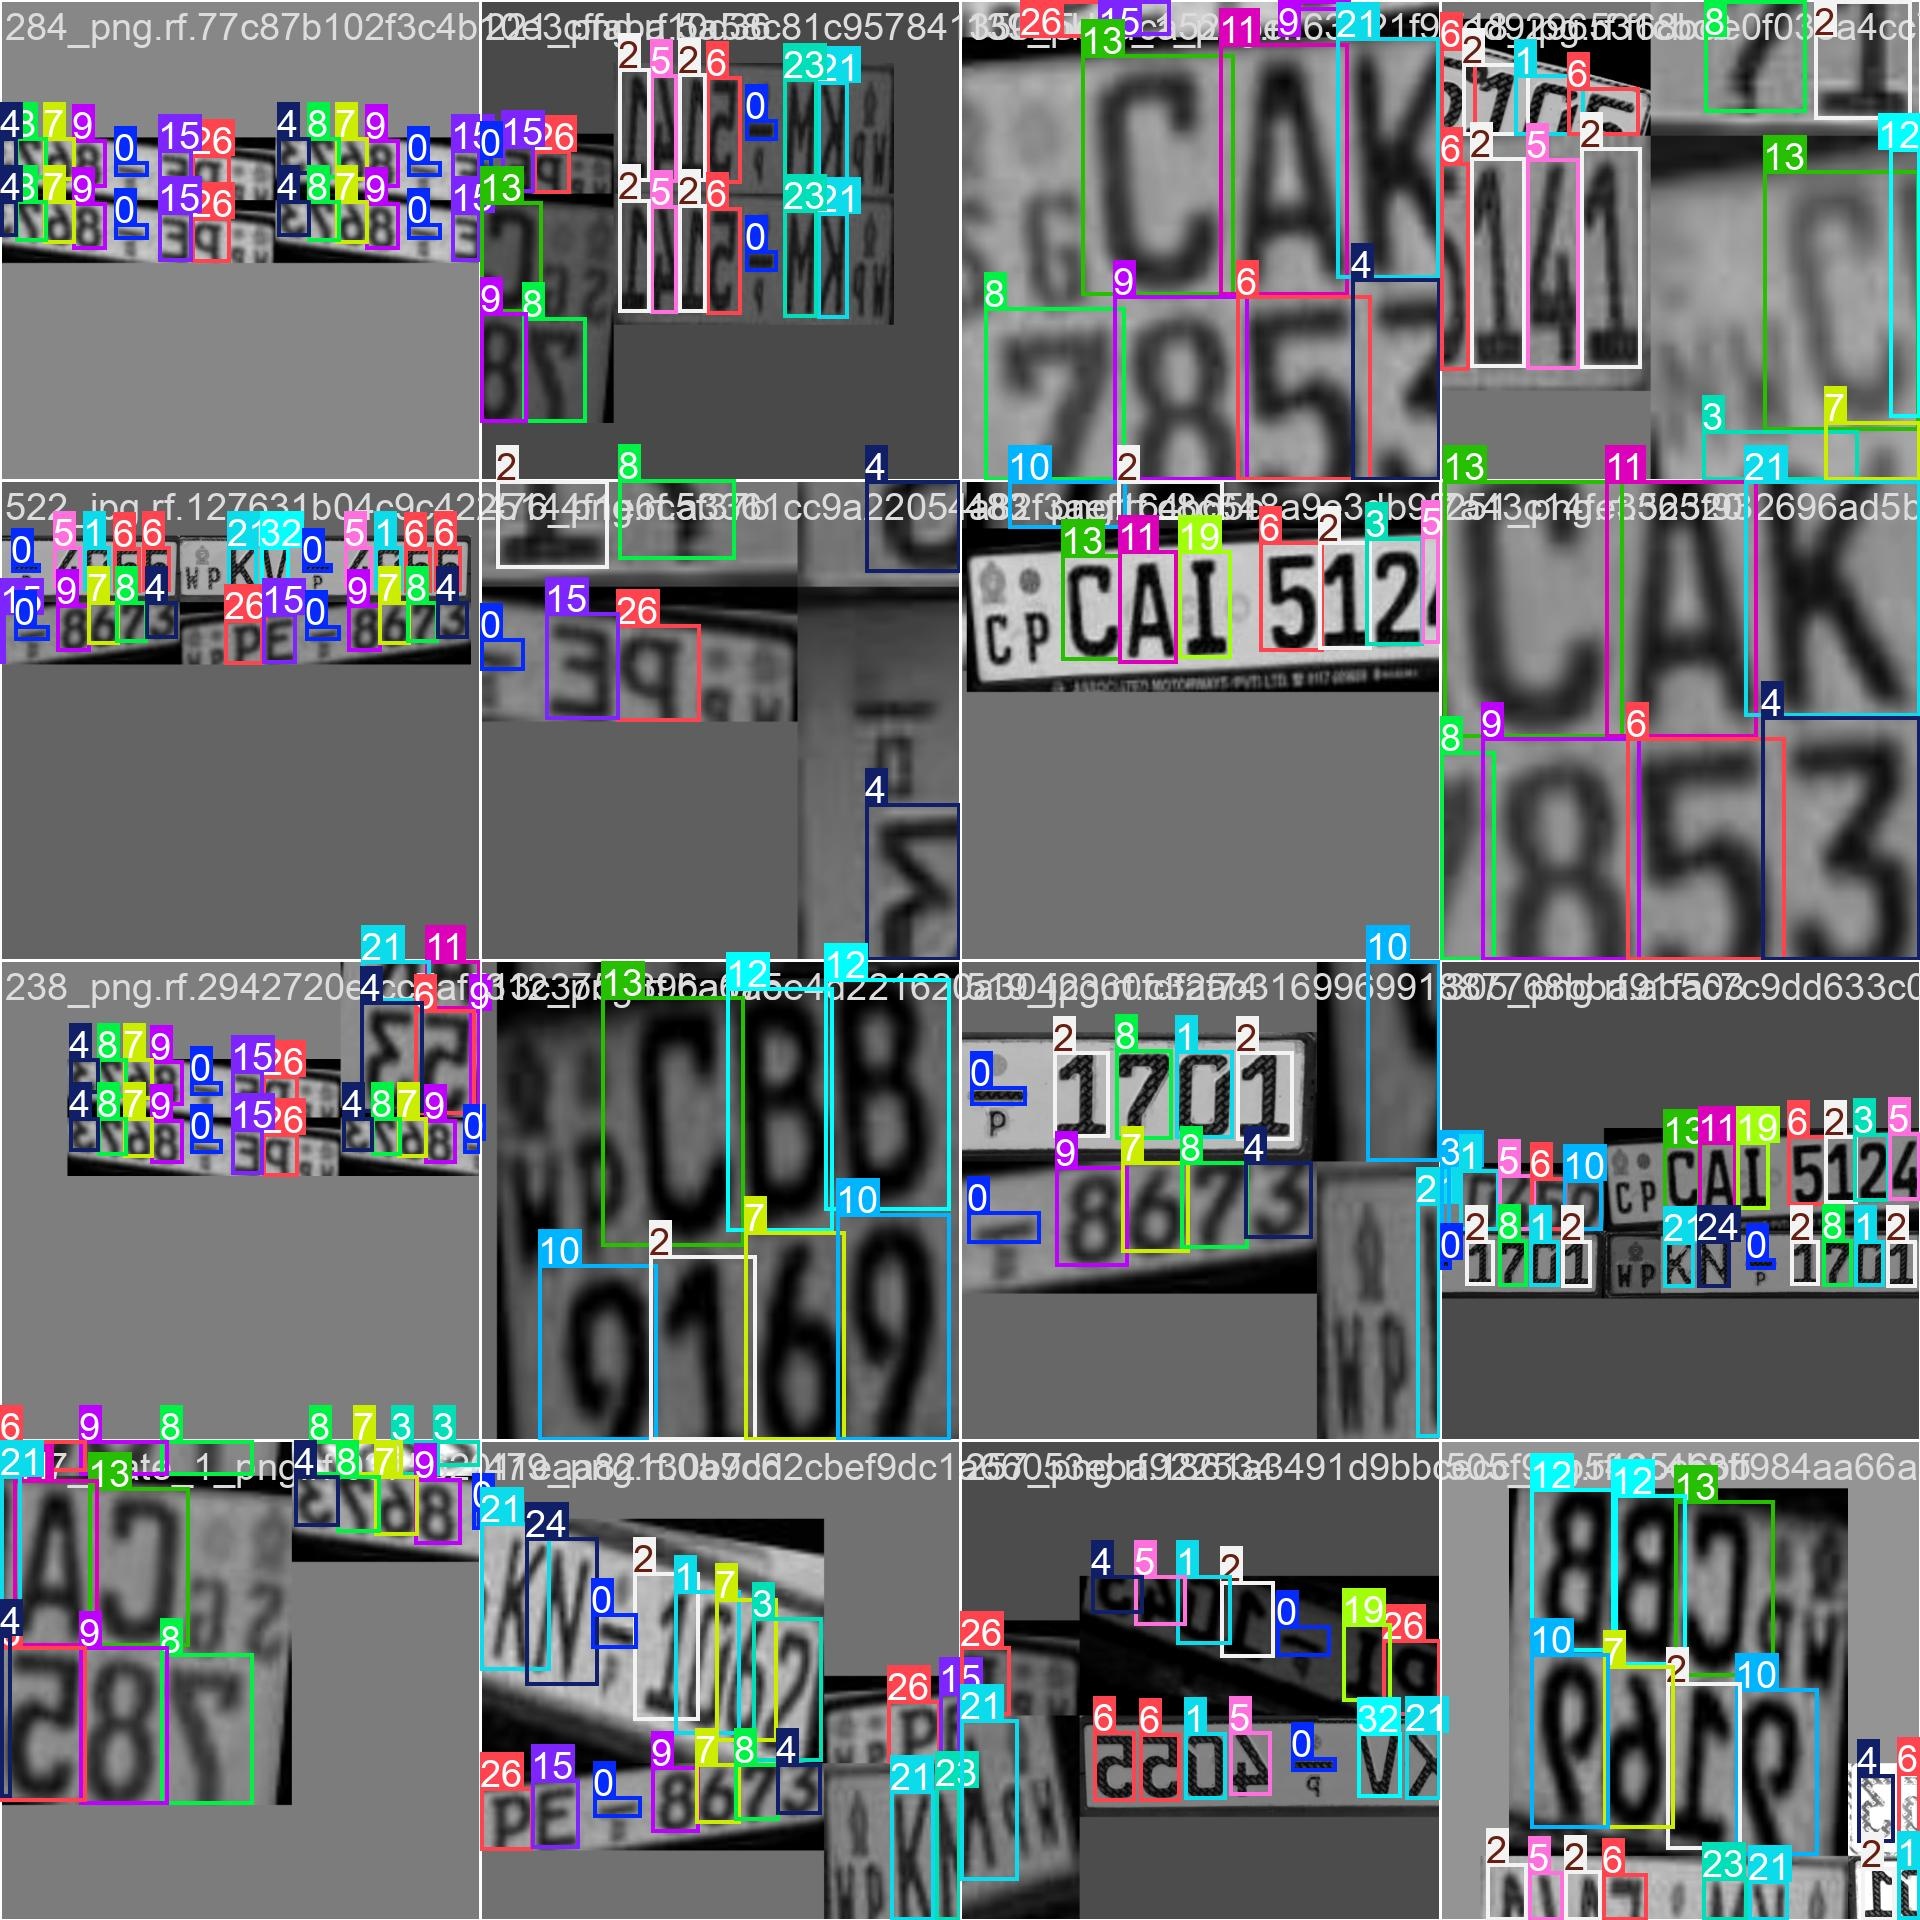


Validation Batch - Ground Truth Labels:


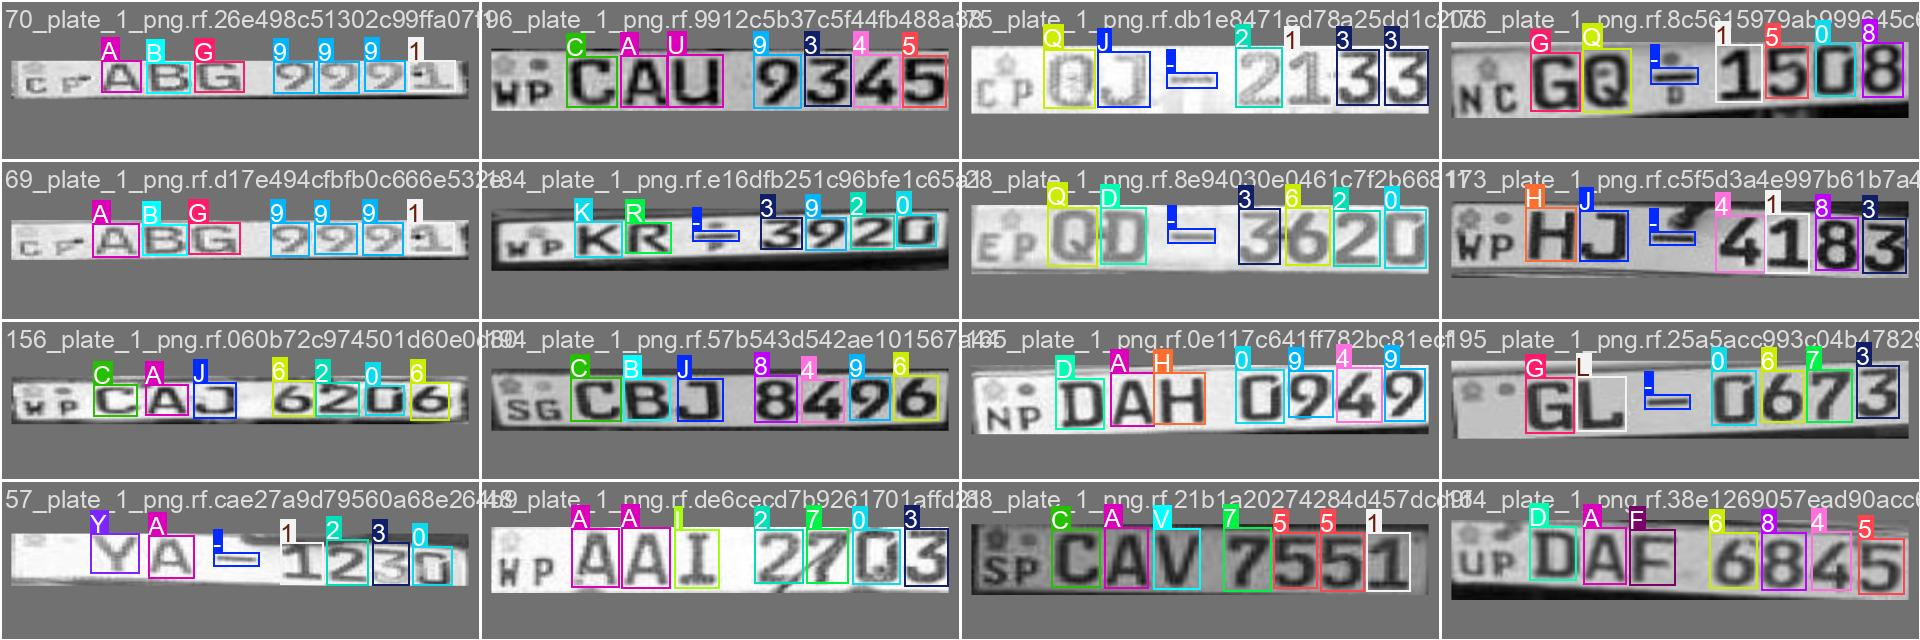


Validation Batch - Model Predictions:


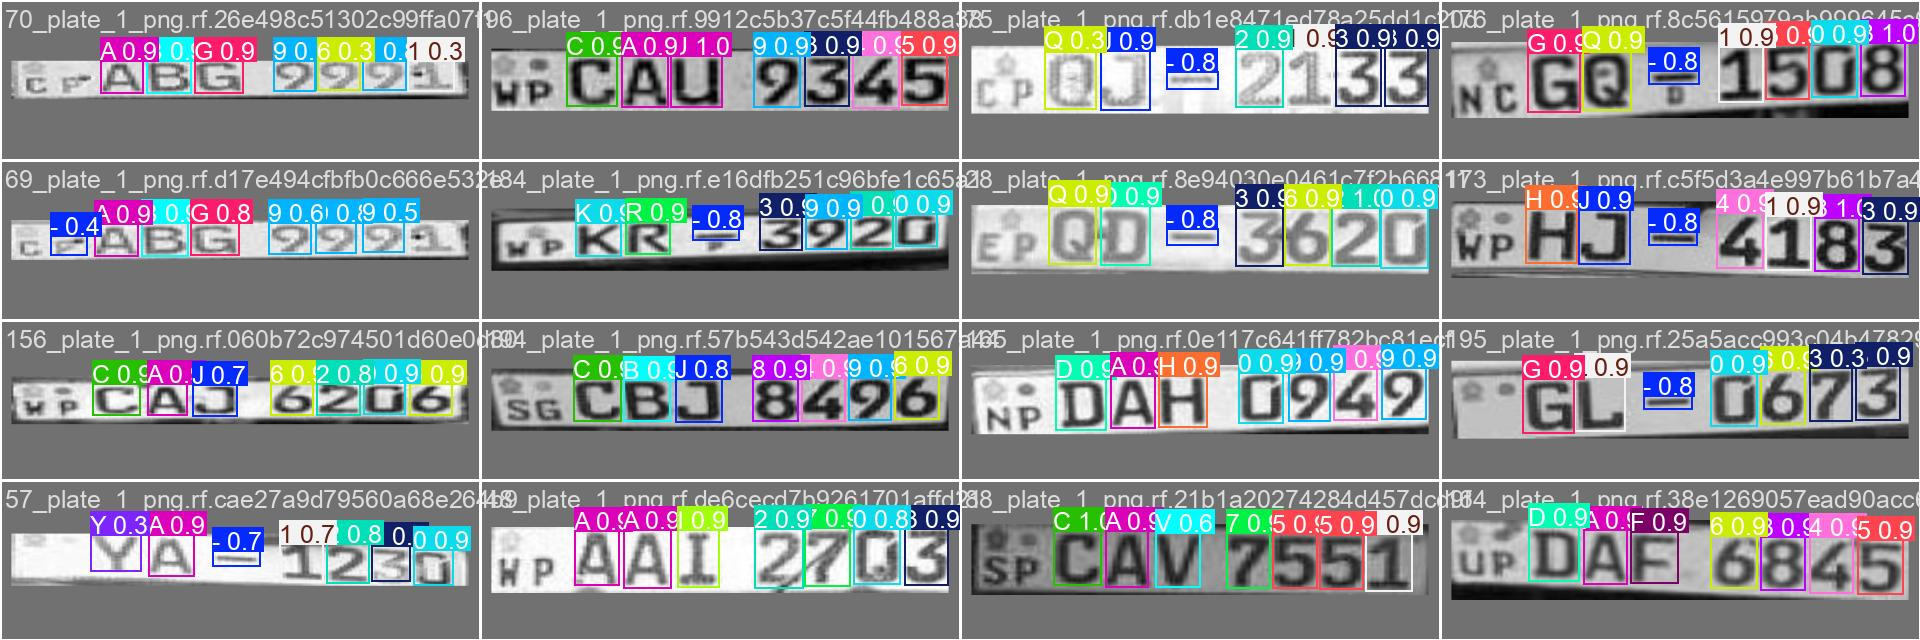


📸 Sample Original Dataset Images:
Training Samples:
Training Image 1: 336_png.rf.d049c7010d788d6359068056eff6b472.jpg


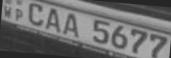

Training Image 2: 453_png.rf.f2f1c9bd50c375067eeae61e92585adf.jpg


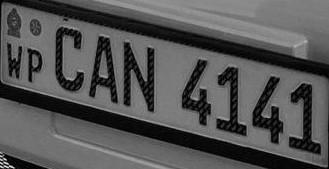

Training Image 3: 473_png.rf.6c2adba295778c130650eef4a65c3e35.jpg


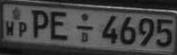

Validation Samples:
Validation Image 1: 36_plate_1_png.rf.246c327354689dc64051399689383893.jpg


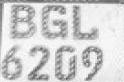

Validation Image 2: 176_plate_1_png.rf.8c5615979ab999645c64f2a2447ea0d3.jpg


In [11]:
results_path = "runs/detect/sri_lanka_license_plate_detection/results.png"
if os.path.exists(results_path):
    print("Training curves:")
    display(Image(filename=results_path))
else:
    print("❌ Results plot not found")

print("\n📊 Training and Validation Batch Images:")

train_batch_path = "runs/detect/sri_lanka_license_plate_detection/train_batch0.jpg"
if os.path.exists(train_batch_path):
    print("Training Batch Sample:")
    display(Image(filename=train_batch_path))
else:
    print("❌ Training batch image not found")

val_batch_labels_path = "runs/detect/sri_lanka_license_plate_detection/val_batch0_labels.jpg"
val_batch_pred_path = "runs/detect/sri_lanka_license_plate_detection/val_batch0_pred.jpg"

if os.path.exists(val_batch_labels_path):
    print("\nValidation Batch - Ground Truth Labels:")
    display(Image(filename=val_batch_labels_path))

if os.path.exists(val_batch_pred_path):
    print("\nValidation Batch - Model Predictions:")
    display(Image(filename=val_batch_pred_path))

print("\n📸 Sample Original Dataset Images:")
sample_train_imgs = glob.glob("/content/dataset/train/images/*.jpg")[:3]
sample_val_imgs = glob.glob("/content/dataset/valid/images/*.jpg")[:2]

print("Training Samples:")
for i, img_path in enumerate(sample_train_imgs):
    print(f"Training Image {i+1}: {os.path.basename(img_path)}")
    display(Image(filename=img_path, width=400))

print("Validation Samples:")
for i, img_path in enumerate(sample_val_imgs):
    print(f"Validation Image {i+1}: {os.path.basename(img_path)}")
    display(Image(filename=img_path, width=400))

# **7. MODEL PERFORMANCE SUMMARY**

In [12]:
import pandas as pd

In [13]:
try:
    results_csv = "runs/detect/sri_lanka_license_plate_detection/results.csv"
    df = pd.read_csv(results_csv)

    final_metrics = df.iloc[-1]

    print(f"Final Epoch: {int(final_metrics['epoch'])}")
    print(f"Training Loss: {final_metrics['train/box_loss']:.4f}")
    print(f"Validation Loss: {final_metrics['val/box_loss']:.4f}")
    print(f"mAP@0.5: {final_metrics['metrics/mAP50(B)']:.4f}")
    print(f"mAP@0.5:0.95: {final_metrics['metrics/mAP50-95(B)']:.4f}")
    print(f"Precision: {final_metrics['metrics/precision(B)']:.4f}")
    print(f"Recall: {final_metrics['metrics/recall(B)']:.4f}")

    mAP50 = final_metrics['metrics/mAP50(B)']
    if mAP50 > 0.9:
        print("🏆 Excellent performance!")
    elif mAP50 > 0.8:
        print("✅ Very good performance!")
    elif mAP50 > 0.7:
        print("👍 Good performance!")
    elif mAP50 > 0.5:
        print("⚠️ Moderate performance - consider more training or data")
    else:
        print("❌ Poor performance - review dataset and parameters")

except Exception as e:
    print(f"Could not load results: {e}")

print("="*60)

Final Epoch: 77
Training Loss: 0.4743
Validation Loss: 0.7388
mAP@0.5: 0.9659
mAP@0.5:0.95: 0.8065
Precision: 0.9010
Recall: 0.9279
🏆 Excellent performance!


# **8. VALIDATION AND GENERATE METRICS**

In [14]:
metrics = model.val()

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,427,119 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 144.9±104.1 MB/s, size: 3.9 KB)


val: Scanning /content/dataset/valid/labels.cache... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


                   all         77        534      0.904      0.937      0.976      0.813
                     -         19         19      0.958          1      0.995      0.649
                     0         28         32      0.981      0.969      0.977      0.809
                     1         22         26          1      0.953      0.993      0.848
                     2         38         40      0.958          1      0.995      0.839
                     3         27         29      0.978          1      0.995      0.798
                     4         20         27      0.975          1      0.995      0.745
                     5         26         31      0.974          1      0.995       0.86
                     6         27         33      0.957       0.97      0.963      0.791
                     7         27         29      0.968          1      0.995      0.822
                     8         21         25      0.971          1      0.995      0.824
                     

# **9. RUN INFERENCE ON VALIDATION IMAGES**

In [15]:
import glob
import shutil
import random

Testing on 3 random validation images...

--- Testing Image 1 ---

image 1/1 /content/sample_1.jpg: 288x640 1 2, 2 5s, 1 7, 1 A, 1 B, 1 T, 48.8ms
Speed: 1.4ms preprocess, 48.8ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/sri_lanka_plate_prediction_1
✅ Prediction successful for image 1
Original: 61_plate_1_png.rf.065094db2006645ccfe162a0fabf9bac.jpg


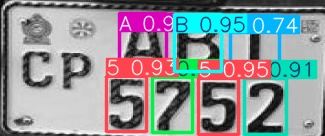

🎯 Detected 7 license plate(s):
   Plate 1: Confidence 0.955
   Plate 2: Confidence 0.946
   Plate 3: Confidence 0.935
   Plate 4: Confidence 0.927
   Plate 5: Confidence 0.913
   Plate 6: Confidence 0.913
   Plate 7: Confidence 0.738

--- Testing Image 2 ---

image 1/1 /content/sample_2.jpg: 96x640 1 0, 1 2, 1 3, 1 7, 2 As, 1 I, 47.7ms
Speed: 1.3ms preprocess, 47.7ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)
Results saved to runs/detect/sri_lanka_plate_prediction_2
✅ Prediction successful for image 2
Original: 48_plate_1_png.rf.de6cecd7b9261701affd21f1e07e72b2.jpg


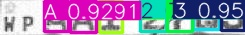

🎯 Detected 7 license plate(s):
   Plate 1: Confidence 0.946
   Plate 2: Confidence 0.915
   Plate 3: Confidence 0.907
   Plate 4: Confidence 0.904
   Plate 5: Confidence 0.897
   Plate 6: Confidence 0.885
   Plate 7: Confidence 0.871

--- Testing Image 3 ---

image 1/1 /content/sample_3.jpg: 192x640 1 -, 1 0, 1 2, 1 4, 1 8, 1 G, 1 K, 52.2ms
Speed: 1.4ms preprocess, 52.2ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 640)
Results saved to runs/detect/sri_lanka_plate_prediction_3
✅ Prediction successful for image 3
Original: 84_plate_1_png.rf.c05d6fbee41222ecdebaa452d9d5df38.jpg


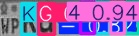

🎯 Detected 7 license plate(s):
   Plate 1: Confidence 0.939
   Plate 2: Confidence 0.935
   Plate 3: Confidence 0.929
   Plate 4: Confidence 0.926
   Plate 5: Confidence 0.918
   Plate 6: Confidence 0.891
   Plate 7: Confidence 0.825


In [16]:
trained_model = YOLO("runs/detect/sri_lanka_license_plate_detection/weights/best.pt")

val_images = glob.glob("/content/dataset/valid/images/*.jpg") + glob.glob("/content/dataset/valid/images/*.png")

if val_images:
    num_test_images = min(3, len(val_images))
    sample_images = random.sample(val_images, num_test_images)

    print(f"Testing on {num_test_images} random validation images...")

    for i, sample_image in enumerate(sample_images):
        print(f"\n--- Testing Image {i+1} ---")
        sample_name = f"sample_{i+1}.jpg"
        shutil.copy(sample_image, f"/content/{sample_name}")

        results = trained_model.predict(
            source=f"/content/{sample_name}",
            save=True,
            imgsz=640,
            conf=0.35,
            name=f"sri_lanka_plate_prediction_{i+1}"
        )

        pred_img_path = f"runs/detect/sri_lanka_plate_prediction_{i+1}/{sample_name}"
        if os.path.exists(pred_img_path):
            print(f"✅ Prediction successful for image {i+1}")
            print(f"Original: {os.path.basename(sample_image)}")
            display(Image(filename=pred_img_path))

            for r in results:
                if len(r.boxes) > 0:
                    print(f"🎯 Detected {len(r.boxes)} license plate(s):")
                    for j, box in enumerate(r.boxes):
                        conf = box.conf[0].item()
                        print(f"   Plate {j+1}: Confidence {conf:.3f}")
                else:
                    print("❌ No license plates detected")
        else:
            print(f"❌ Prediction failed for image {i+1}")

else:
    print("❌ No validation images found in dataset")

# **10. EXPORT ALL RESULTS TO GOOGLE DRIVE**

In [18]:
import random

In [17]:
output_dir = "/content/drive/MyDrive/Model_Training/License_Plate_Recognition/Output"
os.makedirs(output_dir, exist_ok=True)

def copy_file_safely(src, dst, description):
    try:
        if os.path.exists(src):
            shutil.copy2(src, dst)
            print(f"✅ {description}")
            return True
        else:
            print(f"⚠️ {description} - file not found")
            return False
    except Exception as e:
        print(f"❌ {description} - error: {e}")
        return False

print("Exporting files...")
copy_file_safely("runs/detect/sri_lanka_license_plate_detection/results.png",
                 f"{output_dir}/training_results.png", "Training curves")
copy_file_safely("runs/detect/sri_lanka_license_plate_detection/confusion_matrix.png",
                 f"{output_dir}/confusion_matrix.png", "Confusion matrix")
copy_file_safely("runs/detect/sri_lanka_license_plate_detection/results.csv",
                 f"{output_dir}/training_metrics.csv", "Training metrics")
copy_file_safely("runs/detect/sri_lanka_license_plate_detection/weights/best.pt",
                 f"{output_dir}/best_model.pt", "Best model weights")
copy_file_safely("runs/detect/sri_lanka_license_plate_detection/weights/last.pt",
                 f"{output_dir}/last_model.pt", "Last model checkpoint")

val_batch_labels = "runs/detect/sri_lanka_license_plate_detection/val_batch0_labels.jpg"
val_batch_pred = "runs/detect/sri_lanka_license_plate_detection/val_batch0_pred.jpg"
train_batch = "runs/detect/sri_lanka_license_plate_detection/train_batch0.jpg"

copy_file_safely(val_batch_labels, f"{output_dir}/validation_labels.jpg", "Validation labels")
copy_file_safely(val_batch_pred, f"{output_dir}/validation_predictions.jpg", "Validation predictions")
copy_file_safely(train_batch, f"{output_dir}/train_batch_sample.jpg", "Training batch sample")

for batch_num in range(1, 4):
    val_batch_extra = f"runs/detect/sri_lanka_license_plate_detection/val_batch{batch_num}_pred.jpg"
    if os.path.exists(val_batch_extra):
        copy_file_safely(val_batch_extra, f"{output_dir}/validation_batch_{batch_num}.jpg",
                        f"Validation batch {batch_num}")

print("\n📸 Exporting sample dataset images...")
import random

train_sample_images = glob.glob("/content/dataset/train/images/*.jpg")[:5]
for i, img_path in enumerate(train_sample_images):
    copy_file_safely(img_path, f"{output_dir}/train_sample_{i+1}.jpg",
                    f"Training sample {i+1}")

val_sample_images = glob.glob("/content/dataset/valid/images/*.jpg")[:3]
for i, img_path in enumerate(val_sample_images):
    copy_file_safely(img_path, f"{output_dir}/validation_sample_{i+1}.jpg",
                    f"Validation sample {i+1}")

print("📋 Exporting sample label files...")
for i, img_path in enumerate(train_sample_images):
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    if os.path.exists(label_path):
        copy_file_safely(label_path, f"{output_dir}/train_sample_{i+1}.txt",
                        f"Training label {i+1}")

for i, img_path in enumerate(val_sample_images):
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    if os.path.exists(label_path):
        copy_file_safely(label_path, f"{output_dir}/validation_sample_{i+1}.txt",
                        f"Validation label {i+1}")

for i in range(1, 4):
    pred_path = f"runs/detect/sri_lanka_plate_prediction_{i}/sample_{i}.jpg"
    if os.path.exists(pred_path):
        copy_file_safely(pred_path, f"{output_dir}/prediction_example_{i}.jpg",
                        f"Prediction example {i}")

try:
    files = os.listdir(output_dir)
    for file in sorted(files):
        file_path = os.path.join(output_dir, file)
        size = os.path.getsize(file_path)
        size_mb = size / (1024 * 1024)
        print(f"  📄 {file} ({size_mb:.2f} MB)")
except Exception as e:
    print(f"❌ Error listing files: {e}")

Exporting files...
✅ Training curves
✅ Confusion matrix
✅ Training metrics
✅ Best model weights
✅ Last model checkpoint
✅ Validation labels
✅ Validation predictions
✅ Training batch sample
✅ Validation batch 1
✅ Validation batch 2

📸 Exporting sample dataset images...
✅ Training sample 1
✅ Training sample 2
✅ Training sample 3
✅ Training sample 4
✅ Training sample 5
✅ Validation sample 1
✅ Validation sample 2
✅ Validation sample 3
📋 Exporting sample label files...
✅ Training label 1
✅ Training label 2
✅ Training label 3
✅ Training label 4
✅ Training label 5
✅ Validation label 1
✅ Validation label 2
✅ Validation label 3
✅ Prediction example 1
✅ Prediction example 2
✅ Prediction example 3
  📄 best_model.pt (18.32 MB)
  📄 confusion_matrix.png (0.12 MB)
  📄 last_model.pt (18.32 MB)
  📄 prediction_example_1.jpg (0.02 MB)
  📄 prediction_example_2.jpg (0.01 MB)
  📄 prediction_example_3.jpg (0.00 MB)
  📄 train_batch_sample.jpg (0.49 MB)
  📄 train_sample_1.jpg (0.00 MB)
  📄 train_sample_1.txt (